In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import re
import string
from collections import defaultdict
from tqdm import tqdm_notebook
from pandas_summary import DataFrameSummary
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score, auc as sk_auc, roc_curve, precision_score, recall_score
from nltk.stem.snowball import SnowballStemmer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack, csr_matrix

%load_ext autoreload
%autoreload 2
%matplotlib inline

pd.options.display.max_colwidth = 300
pd.options.display.max_columns = 30
pd.options.display.max_rows = 5000
seed = 42
np.random.seed(seed)

# Constants

In [2]:
data_path = '../data/'
DROP_DUPLICATES = True
TFIDF = True
SCENARIO1 = False
SCENARIO2 = True
SCENARIO3 = False
REGEX_FEATURES = False
BUSINESS_CODE = True
BUSINESS_LEVEL = 3
if SCENARIO1 + SCENARIO2 + SCENARIO3 != 1:
    raise Exception('Exactly 1 scenario should be selected')
    
if SCENARIO2:
    TEST_SET_FRAC = 0.25
    MAX_SIZE_DEV = 0.05
    CATALOG_MIN_ENTRIES = 200

# Load in data from pickle

In [3]:
BUSINESS_ADDITION = ''
if BUSINESS_CODE:
    BUSINESS_ADDITION = '_business'
if SCENARIO1:
    df = pd.read_pickle(data_path + '2017-2018' + BUSINESS_ADDITION + '.pkl')
    df.shape
else:
    if SCENARIO2:
        version = '_scen2'
    else:
        version = '_scen3'
    df = pd.read_pickle(data_path + 'catalog201810' + version + BUSINESS_ADDITION + '.pkl')
    df.shape

# Split into train and test set, mode decides which dataset is used

In [4]:
df['Label'] = df['Label'].astype('str')
df = df.loc[df['Label'].map(~(df['Label'].value_counts()<2))]
y = df['Label']

## Split into train and testset. Stratify the split for scenario 1 and 3. Select data from certain catalogs for scenario 2

In [6]:
if SCENARIO1 or SCENARIO3:
    if BUSINESS_CODE:
        X_train, X_test, y_train, y_test = train_test_split(df.loc[:, ['ProductName', 'Full_code']], y, stratify=y)
    else:
        X_train, X_test, y_train, y_test = train_test_split(df['ProductName'], y, stratify=y)

In [7]:
if SCENARIO2:
    # only consider data from catalogs of a certain size for the test set
    catalogs = df['CatalogueID'].value_counts().to_dict()
    catalogs_test_potentials = {}
    for k, v in catalogs.items():
        if v >= CATALOG_MIN_ENTRIES:
            catalogs_test_potentials[k] = v
    
    # ensure that the extracted catalogs for the test set is neither too large or too small
    ideal_test_set_size = df.shape[0]*TEST_SET_FRAC
    max_test_set_dev = df.shape[0]*MAX_SIZE_DEV
    mean_potential_cat_sz = np.mean(list(catalogs_test_potentials.values()))
    n_test_cats = int(ideal_test_set_size/mean_potential_cat_sz)
    test_set_found = False
    while not test_set_found:
        selection = np.random.choice(list(catalogs_test_potentials.keys()), size=n_test_cats, replace=False)
        size = 0
        for k in selection:
            size += catalogs_test_potentials[k]
        if np.abs(size-ideal_test_set_size) <= max_test_set_dev:
            test_set_found = True
        selection = set(selection)
        print(test_set_found)
    
    mask = (df['CatalogueID'].isin(selection))
    df_train = df.loc[~mask]
    df_test = df.loc[mask]
    if BUSINESS_CODE:
        X_train = df_train.loc[:, ['ProductName', 'Full_code', 'CatalogueID']]
        X_test = df_test.loc[:, ['ProductName', 'Full_code', 'CatalogueID']]
    else:
        X_train = df_train.loc[:, ['ProductName']]
        X_test = df_test.loc[:, ['ProductName']]
    y_train = df_train['Label']
    y_test = df_test['Label']

True


In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2996681, 3), (2996681, 1), (1006375, 3), (1006375, 1))

## Identify descriptions with multiple correct answers

In [9]:
%%time
product_label_map = {}
for product_name, label in df.loc[:, ['ProductName', 'Label']].values:
    if product_name not in product_label_map:
        product_label_map[product_name] = [label]
    else:
        product_label_map[product_name].append(label)


Wall time: 6.5 s


In [10]:
product_label_map

{'HYLLE TIL TRANSPORTCONTAINER': ['101316'],
 'TRANSPORTCONTAINER COMPACTAIN': ['101316'],
 'TRANSPORTCONTAINER FOLDIA': ['101316'],
 'TRANSPORTCONTAINER SMART CUBE': ['101316'],
 'Plastakvarium/Terrarium': ['101317',
  '101317',
  '101317',
  '101317',
  '101317',
  '101317',
  '101317',
  '101317',
  '101317',
  '101317',
  '101317',
  '101317',
  '101317',
  '101317',
  '101317',
  '101317',
  '101317',
  '101317',
  '101317',
  '101317',
  '101317',
  '101317'],
 'TAHIN 12 GL': ['101516', '101516', '101516', '101516', '101516', '101516'],
 'SAFRAN PK 1 GRAM': ['101518',
  '101518',
  '101518',
  '101518',
  '101518',
  '101518'],
 'GRØNNSAKSMIX JULIENNE 1 KG GULROT / HODEKÅL': ['101524', '501015', '504026'],
 'RATATOUILLE': ['101524'],
 'REDDIK JULIENNE 1 KG': ['101524'],
 'REDDIKER BT': ['101524'],
 'RETTICH': ['101524'],
 'RETTICH STAVER': ['101524'],
 'SPIRER REDIKKSPIRER': ['101524', '504026'],
 'MOSEFJERNER TAK GTI 1L RENGJØRING AV TAK OG BETONGHELLER': ['101717'],
 'UGRESSMID

# Define helper functions

In [11]:
# Functions to remove unhelpful characters and split document into lower-case words

def remove_punctuation(document):
    return "".join([ (c if c not in string.punctuation+"\n\r\t" else " ") for c in document])

def remove_nums(document):
    pattern = r'^.*[0-9]+.*$'
    return [w for w in document.split(' ') if not re.match(pattern, w)]

def tokenize(document):
    stemmer = SnowballStemmer('norwegian')
    return [stemmer.stem(w.lower()) for w in remove_nums(remove_punctuation(document)) if len(w)>0]

## Get list of Norwegian stop words, then use the stemmer on these in order to correctly omit stop words

In [12]:
stoplist = []
with open('../data/stoppord.txt', 'r', encoding='utf8') as f:
    stoplist = f.read().split('\n')

In [13]:
stemmed_stop = []
stemmer = SnowballStemmer('norwegian')
for word in stoplist:
    stemmed_stop.append(stemmer.stem(word))

## Transform the titles into samples with one feature per word (the occurrence count of the word in the given title)

In [14]:
# Optional use of TfidfVectorizer
if TFIDF:
    vec = TfidfVectorizer(tokenizer=tokenize, stop_words=stemmed_stop, ngram_range=(1,2))
else:
    vec = CountVectorizer(tokenizer=tokenize, stop_words=stemmed_stop, ngram_range=(1,2))
    
# Add a feature for each token with its occurrence count for each title
if BUSINESS_CODE:
    trn_vec= vec.fit_transform(X_train['ProductName'].values)
    test_vec = vec.transform(X_test['ProductName'].values)
else:
    trn_vec= vec.fit_transform(X_train.values)
    test_vec = vec.transform(X_test.values)
len(vec.get_feature_names())

712101

# Add business domain features if specified

In [15]:
if BUSINESS_CODE:
    train_codes = pd.get_dummies(X_train['Full_code'].map(lambda x: x[:BUSINESS_LEVEL]))
    test_codes = pd.get_dummies(X_test['Full_code'].map(lambda x: x[:BUSINESS_LEVEL]))
    # Making sure the columns have the same order
    test_codes = test_codes.loc[:,train_codes.columns]
    # Some codes may only be present in train, and needs to be filled with 0
    test_codes = test_codes.fillna(0)
    
    # concat new features to the sparse matrix
    trn_vec = hstack([trn_vec, csr_matrix(train_codes)])
    test_vec = hstack([test_vec, csr_matrix(test_codes)])
    

C:\Users\BJOVAS\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


# Metadata and number features

In [16]:
REGEX_MIN_OCC = 4000

## Helper functions

In [17]:
def add_space(document):
    return ''.join([c if c not in '\n\r\t' else ' ' for c in document])

def remove_special(document):
    illegal = ''.join([c if c not in '.,' else '' for c in string.punctuation])
    return ''.join([c if c not in illegal else ' ' for c in document])

def get_regex_matches(df, business_code):
    float_pattern = r'^[0-9]+(,|\.)[0-9]*$'
    int_pattern = r'^[0-9]+$'
    left_pattern = r'([^0-9^ .]+) *[0-9]+([,|\.][0-9]*)?'
    right_pattern = r'[0-9]+([,|\.][0-9]*)? *([^0-9^ .]+)'
    
    num_matches = {'int':set([]), 'float':set([]), 'num':set([])}
    word_matches = defaultdict(lambda: set([]))
    if business_code:
        descriptions = df['ProductName'].values
    else:
        descriptions = df.values

    for i, words in tqdm_notebook(enumerate(descriptions)):
        spaced_words = add_space(words)
        processed_words = remove_special(words)
        left_m = re.findall(left_pattern, processed_words)
        right_m = re.findall(right_pattern, processed_words)

        if left_m:
            for match in left_m:
                word_matches[match[0].lower()].add(i)
        if right_m:
            for match in right_m:
                word_matches[match[-1].lower()].add(i)
        for word in processed_words.split(' '):
            int_m = re.match(int_pattern, word)
            float_m = re.match(float_pattern, word)

            if bool(int_m) or bool(float_m):
                num_matches['num'].add(i)
            if int_m:
                num_matches['int'].add(i)
            if float_m:
                num_matches['float'].add(i)
    return num_matches, word_matches

In [18]:
if REGEX_FEATURES:
    num_matches, word_matches = get_regex_matches(X_train, BUSINESS_CODE)

## Reduce noise by only looking at word + num combinations that occur more than X times in the training dataset

In [20]:
if REGEX_FEATURES:
    kept_matches = {}
    for k, v in word_matches.items():
        if len(v) >= REGEX_MIN_OCC:
            kept_matches[k] = v
    kept_matches.keys()

## Prepare one-hot encoded features for train data

In [23]:
if REGEX_FEATURES:
    train_regex_features = np.zeros((X_train.shape[0], len(kept_matches.keys())+3), dtype='int32')
    n = len(kept_matches.keys())
    cols = list(kept_matches.keys())
    col_map = {}
    for i, k in enumerate(cols):
        col_map[k] = i
    for i, v in enumerate(kept_matches.values()):
        train_regex_features[np.array(list(v), dtype='int32'), i] = 1
    numericals = list(num_matches.keys())
    cols.extend(numericals)
    for i, v in enumerate(num_matches.values()):
        train_regex_features[np.array(list(v), dtype='int32'), i+n] = 1

## Prepare one-hot encoded features for test data, based on kept regex matches from train

In [27]:
if REGEX_FEATURES:
    num_matches, word_matches = get_regex_matches(X_test, BUSINESS_CODE)

    test_kept_matches = {}
    for k, v in word_matches.items():
        if k in kept_matches:
            test_kept_matches[k] = v

    test_regex_features = np.zeros((X_test.shape[0], len(kept_matches.keys())+3), dtype='int32')
    for k in kept_matches.keys():
        if k in test_kept_matches:
            test_regex_features[np.array(list(test_kept_matches[k]), dtype='int32'), col_map[k]] = 1
    numericals = list(num_matches.keys())
    for i, v in enumerate(num_matches.values()):
        test_regex_features[np.array(list(v), dtype='int32'), i+n] = 1

In [30]:
if REGEX_FEATURES:
    trn_vec = hstack([trn_vec, csr_matrix(train_regex_features)])
    test_vec = hstack([test_vec, csr_matrix(test_regex_features)])

## Fit model

In [31]:
%%time
#m = MultinomialNB()
#m = LogisticRegression(class_weight='balanced', n_jobs=5, solver='saga', multi_class='multinomial', penalty='l1', verbose=1)
m = LogisticRegression(class_weight='balanced', multi_class='ovr', solver='liblinear', verbose=1)
m.fit(trn_vec, y_train)

C:\Users\BJOVAS\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]Wall time: 5h 19min 7s


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=1,
                   warm_start=False)

In [32]:
preds = m.predict_proba(test_vec)

In [33]:
label_cols = m.classes_

# Evaluation

In [34]:
df_preds = pd.DataFrame(preds, columns=m.classes_)
df_preds.head()

,101317,101516,101518,101524,101717,101915,101917,103422,111015,111017,111115,111116,111117,111118,111215,...,821416,841015,851216,861016,861115,901016,901019,911015,911115,921019,921217,941320,951316,951415,951416
0,0.000025,0.000027,0.000027,0.000030,0.000028,0.000612,0.000032,0.000045,0.000039,0.000017,0.000028,0.000025,0.000035,0.000032,0.000025,...,0.000025,0.000038,0.000037,0.000032,0.000025,0.000049,0.000027,0.000029,0.000045,0.000024,0.000044,0.000047,0.000026,0.000028,0.000028
1,0.000048,0.000051,0.000051,0.000058,0.000054,0.001180,0.000062,0.000086,0.000075,0.000035,0.000053,0.000049,0.000068,0.000063,0.000049,...,0.000048,0.000073,0.000071,0.000063,0.000049,0.000093,0.000052,0.000057,0.000086,0.000046,0.000085,0.000089,0.000049,0.000054,0.000056
2,0.000048,0.000051,0.000051,0.000058,0.000054,0.001180,0.000062,0.000086,0.000075,0.000035,0.000053,0.000049,0.000068,0.000063,0.000049,...,0.000048,0.000073,0.000071,0.000063,0.000049,0.000093,0.000052,0.000057,0.000086,0.000046,0.000085,0.000089,0.000049,0.000054,0.000056
3,0.000048,0.000051,0.000050,0.000058,0.000054,0.001164,0.000061,0.000085,0.000074,0.000034,0.000052,0.000048,0.000067,0.000062,0.000048,...,0.000047,0.000069,0.000070,0.000054,0.000048,0.000092,0.000051,0.000056,0.000085,0.000046,0.000083,0.000088,0.000049,0.000053,0.000053
4,0.874821,0.000001,0.000001,0.000001,0.000001,0.000002,0.000014,0.000002,0.000014,0.000064,0.000001,0.000041,0.000002,0.000100,0.000019,...,0.000008,0.000002,0.000002,0.000001,0.000010,0.000002,0.000001,0.000096,0.000002,0.000034,0.000002,0.000002,0.000011,0.000001,0.000001


In [35]:
idxmaxes = np.argmax(df_preds.values, axis=1)

In [36]:
def h_acc(actual, predicted):
    if actual == predicted:
        return 1
    if actual[:4] == predicted[:4]:
        return 0.66
    if actual[:2] == predicted[:2]:
        return 0.33
    return 0

def acc(actual, predicted):
    if actual == predicted:
        return 1
    return 0

def any_acc(actual, predicted):
    return predicted in actual

def any_hacc(actual, predicted):
    scores = []
    for act in actual:
        scores.append(h_acc(act, predicted))
    return np.max(scores)

## Micro scores

In [47]:
score = 0
score_h = 0
score_any = 0
score_any_h = 0
for i, idmax in enumerate(idxmaxes):
    score += acc(y_test.iloc[i].values, label_cols[idmax])
    score_h += h_acc(y_test.iloc[i].values, label_cols[idmax])
    if BUSINESS_CODE:
        score_any += any_acc(product_label_map[X_test['ProductName'].iloc[i]], label_cols[idmax])
        score_any_h += any_hacc(product_label_map[X_test['ProductName'].iloc[i]], label_cols[idmax])
    else:
        score_any += any_acc(product_label_map[X_test.iloc[i]], label_cols[idmax])
        score_any_h += any_hacc(product_label_map[X_test.iloc[i]], label_cols[idmax])
score /= y_test.shape[0]
score_h /= y_test.shape[0]
score_any /= y_test.shape[0]
score_any_h /= y_test.shape[0]


In [48]:
score, score_h, score_any, score_any_h

(0.851975655198112, 0.851975655198112, 0.8928510744006956, 0.9141655247789007)

In [ ]:
#Micro score: 0.9471252726172114

## Class macro scores and statistics

In [148]:
train_label_counts = y_train['Label'].value_counts().to_dict()

In [187]:
train_catalog_counts = X_train['CatalogueID'].value_counts().to_dict()

In [147]:
label_counts = y_test['Label'].value_counts().to_dict()
label_score_dict = defaultdict(lambda: 0)
score = 0
for i, idmax in enumerate(idxmaxes):
    label = y_test['Label'].iloc[i]
    if BUSINESS_CODE:
        label_score_dict[label] += any_acc(product_label_map[X_test['ProductName'].iloc[i]], label_cols[idmax])
    else:
        label_score_dict[label] += any_acc(product_label_map[X_test.iloc[i]], label_cols[idmax])
for label in label_score_dict.keys():
    label_score_dict[label] = label_score_dict[label]/label_counts[label]

201228
241015
241021
311817
311817
241021
311817
241021
241021
241021
241021
531216
531216
531216
241021
241021
241021
241021
241015
241015
241015
241015
241021
241021
241021
241021
241021
241021
241021
241021
241021
241021
241021
241021
241021
241021
241021
241021
241021
241021
311817
311817
311627
311627
241021
241021
601010
311515
311515
491715
521015
491715
521015
491715
521015
491715
311515
311515
311515
311515
491715
521015
491715
521015
491715
521015
491715
311515
311515
311515
311515
491715
521015
491715
521015
491715
521015
491715
311515
311515
311515
311515
311627
491715
521015
491715
521015
491715
521015
491715
311515
311515
311515
311515
491715
521015
491715
521015
491715
521015
491715
311515
311515
311515
311515
491715
521015
491715
521015
491715
521015
491715
391126
391126
391126
391126
411024
561119
271121
241015
311627
241015
311627
271128
301618
301618
271121
271121
271121
271121
271121
271121
441115
441115
441115
441115
441115
441115
441115
441115
441115
441115
441219

561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
301615
301615
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
421918
421918
421918
421918
421918
421918
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
561017
422116
271119
432115
391216
561119
561015
561015
561015
521615
521615
241020
241020
601414
561117
561117
561015
561015
561015
561015
561015
561015
561015
561015
561015
561015
561017
561017
561015
561015
561017
561017
561015
561015
561015
561015
561017
561017
561015
561015
561015
561015
561017
561017
241020
241020
241020

In [175]:
result_df = X_test.loc[:, ['ProductName', 'CatalogueID']]

In [176]:
result_df['Label'] = y_test['Label']

In [181]:
result_df['Predicted'] = list(map(lambda x: label_cols[x], idxmaxes))

In [183]:
result_df['Label count train'] = result_df['Label'].map(train_label_counts)

In [185]:
result_df['Label count test'] = result_df['Label'].map(label_counts)

In [192]:
result_df['CatalogSize'] = result_df['CatalogueID'].map(catalog_counts)

In [221]:
result_df.to_pickle('scen2_results.pkl')


In [224]:
pickle.dump(dict(score_dict), open('catalog_scores.pkl', 'wb'))
pickle.dump(dict(label_score_dict), open('label_scores.pkl', 'wb'))

In [233]:
pickle.dump(product_label_map, open('product_label_map.pkl', 'wb'))

In [223]:
score_dict

defaultdict(<function __main__.<lambda>()>,
            {'NO_WITTUJENS-NO_STATENS_VEGVESEN-NO-2': 0.5968085106382979,
             'NO_BRIO-NO_DRANGEDAL-NO-46993': 0.9774078478002378,
             'NO_BRIO-NO_FITJAR-NO-88642': 0.9792665944607767,
             'NO_BRIO-NO_GAUSDAL-NO-42591': 0.9794147669275264,
             'NO_BRIO-NO_HAMAR-NO-1': 0.752925877763329,
             'NO_BRIO-NO_SANDEFJORD-NO-1': 0.7419489753241322,
             'DK_AVFORMAS-NO_SOGNEKOM-NO-41281': 0.9117180831605902,
             'NO_JULIUS-NO_AKERSH-NO-1': 0.9261012013105205,
             'NO_JULIUS-NO_NESODDEN-NO-81126': 0.9140893470790378,
             'NO_JULIUS-NO_OSLO-NO-1': 0.91201248049922,
             'NO_JULIUS-NO_SKEDSKO-NO-1': 0.9003501211957985,
             'NO_JULIUS-NO_SKIKOM-NO-1': 0.9017742350218565,
             'NO_JULIUS-NO_VESTBY-NO-80245': 0.9140893470790378,
             'NO_NORENGROS-NO_LILLEH-NO-59514': 0.9550274941084054,
             'NO_NORENGROS-NO_RENNE-NO-1': 0.86435977815288

In [194]:
result_df.sample(100)

,ProductName,CatalogueID,Label,Predicted,Label count train,Label count test,CatalogSize
1263254,AKSEL OXP12X280 1SCA022137R5140,NO_ONNINEN-NO_ULLENSAKER-NO-15528,391216,391216,40970.0,23113,38790
926095,ROEBUCK-102345,NO_BRAAS-NO_FORSVARS-NO-1,261117,391213,6137.0,4583,13943
1389785,Sårkontaktlag Cuticerin 20x40cm,NO_HELSESE-NO_TROMSOK-NO-2,421421,421421,983.0,511,9579
1908838,Askebeholder Vesuv gulvmodell,NO_NORENGROS-NO_NEDREEIK-NO-86064,471217,471217,6870.0,3761,1160
2495034,Vintagestrikk : strikkeoppskrifter for smarte klær til alle og enhver : 1935-1955 Nynorsk Innbundet,NO_NORLI-NO_BJERK-NO-1,551015,551015,1347816.0,373573,58006
1676008,HP940XL C4906A BLEKKPATRON SORT,LRECO_AS-NO_NANNESTAD-NO-24325,441031,441031,34968.0,22679,5792
94113,Færre endringer - mer utvilking Bokmål Heftet,NO_NORLI-NO_BJERK-NO-1,551015,551015,1347816.0,373573,58006
4095140,"Kommunalt eierskap : roller, styring og strategi : selskapsdannelse i kommunal sektor Bokmål Heftet",NO_NORLI-NO_TRONDHEIM-NO-1,551015,551015,1347816.0,373573,57991
1852604,BLAKLADER Bukse varsel Marineblå/orange D128,NO_BRAAS-NO_FORSVARS-NO-1,461815,391117,10329.0,8539,13943
2548543,I sommer skal jeg gifte meg med Cecilie Bokmål Heftet,NO_NORLI-NO_FUSAKOMMUNE-NO-13889,551015,551015,1347816.0,373573,60489


In [52]:
X_test['ProductName'].iloc[0]

'HYLLE TIL TRANSPORTCONTAINER'

In [55]:
np.average(list(score_dict.values()))

0.7519797157048024

In [137]:
import pickle

In [143]:
bad_labels = pickle.load(open('badlabels.pkl', 'rb'))

In [140]:
print(bad_labels)

[531316 531316 531316 ... 801017 801017 801017]


In [145]:
for label in bad_labels:
    try:
        print('{}, {}, {}'.format(label_score_dict[str(label)], label_counts[str(label)], label))
    except:
        print(label)

0.7865853658536586, 164, 531025
0.7865853658536586, 164, 531025
0.7865853658536586, 164, 531025
0.7865853658536586, 164, 531025
0.7865853658536586, 164, 531025
0.7865853658536586, 164, 531025
0.7865853658536586, 164, 531025
0.7865853658536586, 164, 531025
0.7871485943775101, 996, 531217
0.7871485943775101, 996, 531217
0.7871485943775101, 996, 531217
0.2857142857142857, 7, 541115
0.2857142857142857, 7, 541115
0.2857142857142857, 7, 541115
0.2857142857142857, 7, 541115
0.2857142857142857, 7, 541115
0.989247311827957, 186, 541116
0.989247311827957, 186, 541116
0.989247311827957, 186, 541116
0.989247311827957, 186, 541116
0.989247311827957, 186, 541116
0.989247311827957, 186, 541116
0.989247311827957, 186, 541116
0.989247311827957, 186, 541116
0.989247311827957, 186, 541116
0.989247311827957, 186, 541116
0.989247311827957, 186, 541116
0.989247311827957, 186, 541116
0.989247311827957, 186, 541116
0.989247311827957, 186, 541116
0.989247311827957, 186, 541116
0.989247311827957, 186, 541116
0.

0.39481996209728365, 1583, 241015
0.39481996209728365, 1583, 241015
0.39481996209728365, 1583, 241015
0.39481996209728365, 1583, 241015
0.39481996209728365, 1583, 241015
0.39481996209728365, 1583, 241015
0.39481996209728365, 1583, 241015
0.39481996209728365, 1583, 241015
0.39481996209728365, 1583, 241015
0.39481996209728365, 1583, 241015
0.39481996209728365, 1583, 241015
0.39481996209728365, 1583, 241015
0.39481996209728365, 1583, 241015
0.39481996209728365, 1583, 241015
0.39481996209728365, 1583, 241015
0.39481996209728365, 1583, 241015
0.39481996209728365, 1583, 241015
0.39481996209728365, 1583, 241015
0.39481996209728365, 1583, 241015
0.39481996209728365, 1583, 241015
0.39481996209728365, 1583, 241015
0.39481996209728365, 1583, 241015
0.39481996209728365, 1583, 241015
0.39481996209728365, 1583, 241015
0.39481996209728365, 1583, 241015
0.39481996209728365, 1583, 241015
0.39481996209728365, 1583, 241015
0.39481996209728365, 1583, 241015
0.39481996209728365, 1583, 241015
0.394819962097

0.027522935779816515, 327, 241019
0.027522935779816515, 327, 241019
0.027522935779816515, 327, 241019
0.027522935779816515, 327, 241019
0.027522935779816515, 327, 241019
0.027522935779816515, 327, 241019
0.027522935779816515, 327, 241019
0.027522935779816515, 327, 241019
0.027522935779816515, 327, 241019
0.027522935779816515, 327, 241019
0.027522935779816515, 327, 241019
0.027522935779816515, 327, 241019
0.027522935779816515, 327, 241019
0.027522935779816515, 327, 241019
0.027522935779816515, 327, 241019
0.027522935779816515, 327, 241019
0.027522935779816515, 327, 241019
0.027522935779816515, 327, 241019
0.027522935779816515, 327, 241019
0.027522935779816515, 327, 241019
0.027522935779816515, 327, 241019
0.027522935779816515, 327, 241019
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.099427381572

0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.099427381572

0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.099427381572

0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.09942738157209786, 3842, 241020
0.099427381572

0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240506329113, 790, 241124
0.31139240

0.600994406463642, 1609, 241215
0.600994406463642, 1609, 241215
0.600994406463642, 1609, 241215
0.600994406463642, 1609, 241215
0.600994406463642, 1609, 241215
0.600994406463642, 1609, 241215
0.600994406463642, 1609, 241215
0.600994406463642, 1609, 241215
0.600994406463642, 1609, 241215
0.600994406463642, 1609, 241215
0.600994406463642, 1609, 241215
0.600994406463642, 1609, 241215
0.600994406463642, 1609, 241215
0.600994406463642, 1609, 241215
0.600994406463642, 1609, 241215
0.600994406463642, 1609, 241215
0.8758262511803588, 2118, 241415
0.8758262511803588, 2118, 241415
0.8758262511803588, 2118, 241415
0.8758262511803588, 2118, 241415
0.8758262511803588, 2118, 241415
0.8758262511803588, 2118, 241415
0.8758262511803588, 2118, 241415
0.8758262511803588, 2118, 241415
0.8758262511803588, 2118, 241415
0.8758262511803588, 2118, 241415
0.8758262511803588, 2118, 241415
0.8758262511803588, 2118, 241415
0.8758262511803588, 2118, 241415
0.8758262511803588, 2118, 241415
0.8758262511803588, 2118, 

0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.5583524027459954, 437, 311627
0.558352

0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.8611177740465339, 4169, 441115
0.86111777

0.9126952342811374, 2497, 441215
0.8479604449938195, 4045, 441216
0.8479604449938195, 4045, 441216
0.8479604449938195, 4045, 441216
0.8479604449938195, 4045, 441216
0.8479604449938195, 4045, 441216
0.8479604449938195, 4045, 441216
0.8479604449938195, 4045, 441216
0.8479604449938195, 4045, 441216
0.8479604449938195, 4045, 441216
0.8479604449938195, 4045, 441216
0.8479604449938195, 4045, 441216
0.8479604449938195, 4045, 441216
0.8479604449938195, 4045, 441216
0.8479604449938195, 4045, 441216
0.8479604449938195, 4045, 441216
0.8479604449938195, 4045, 441216
0.9491092390553791, 14482, 441217
0.9491092390553791, 14482, 441217
0.9491092390553791, 14482, 441217
0.9491092390553791, 14482, 441217
0.9491092390553791, 14482, 441217
0.9491092390553791, 14482, 441217
0.9491092390553791, 14482, 441217
0.9491092390553791, 14482, 441217
0.9491092390553791, 14482, 441217
0.9491092390553791, 14482, 441217
0.9491092390553791, 14482, 441217
0.9491092390553791, 14482, 441217
0.9491092390553791, 14482, 4412

0.0007639419404125286, 1309, 461515
0.0007639419404125286, 1309, 461515
0.0007639419404125286, 1309, 461515
0.0007639419404125286, 1309, 461515
0.0007639419404125286, 1309, 461515
0.0007639419404125286, 1309, 461515
0.0007639419404125286, 1309, 461515
0.0007639419404125286, 1309, 461515
0.0007639419404125286, 1309, 461515
0.0007639419404125286, 1309, 461515
0.0007639419404125286, 1309, 461515
0.0007639419404125286, 1309, 461515
0.0007639419404125286, 1309, 461515
0.0007639419404125286, 1309, 461515
0.0007639419404125286, 1309, 461515
0.0007639419404125286, 1309, 461515
0.0007639419404125286, 1309, 461515
0.0007639419404125286, 1309, 461515
0.0007639419404125286, 1309, 461515
0.0007639419404125286, 1309, 461515
0.0007639419404125286, 1309, 461515
0.0007639419404125286, 1309, 461515
0.0007639419404125286, 1309, 461515
0.0007639419404125286, 1309, 461515
0.0007639419404125286, 1309, 461515
0.0007639419404125286, 1309, 461515
0.0007639419404125286, 1309, 461515
0.0007639419404125286, 1309,

0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.67694762

0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.6769476203137463, 3761, 471217
0.8596658711217183, 2095, 471218
0.8596658711217183, 2095, 471218
0.8596658711217183, 2095, 471218
0.8596658711217183, 2095, 471218
0.85966587

0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.291780821917

0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.29178082191780824, 1460, 551217
0.291780821917

0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.645053355037

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.6450533550370773, 11058, 561015
0.64505335503

0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.6018987341772152, 1580, 561017
0.60189873

In [171]:
label = '561115'

In [172]:
train_label_counts[label], label_counts[label]

(336, 98)

In [57]:
results = []
for key in score_dict:
    results.append((label_counts[key], score_dict[key]))
sorted(results, reverse=True)

[(373573, 0.9945338662055341),
 (87915, 0.7852471136893591),
 (23113, 0.8819711850473759),
 (22679, 0.955597689492482),
 (21742, 0.8942139637567841),
 (14482, 0.9491092390553791),
 (12365, 0.8913061059441973),
 (12013, 0.8284358611504203),
 (11677, 0.8199023721846365),
 (11058, 0.6450533550370773),
 (10008, 0.8886890487609912),
 (9913, 0.9935438313325936),
 (9204, 0.9115601912212081),
 (8875, 0.9068169014084507),
 (8553, 0.9064655676370864),
 (8539, 0.8250380606628411),
 (8535, 0.7511423550087873),
 (6735, 0.7389755011135858),
 (6649, 0.8972777861332532),
 (6123, 0.8949861179160542),
 (6017, 0.9745720458700349),
 (5970, 0.9195979899497487),
 (5874, 0.8748723186925434),
 (5701, 0.8293281880371864),
 (5680, 0.8589788732394367),
 (5295, 0.7503305004721436),
 (5056, 0.935126582278481),
 (4822, 0.8656159270012443),
 (4583, 0.3639537420903338),
 (4573, 0.8528318390553248),
 (4464, 0.878584229390681),
 (4169, 0.8611177740465339),
 (4106, 0.9690696541646371),
 (4045, 0.8479604449938195),
 (384

In [58]:
np.median(np.array(results)[:,1])

0.899820788530466

In [59]:
np.std(np.array(results)[:,1])

0.3250096364531338

## Catalog macro scores and statistics

In [62]:
if SCENARIO2:
    catalog_counts = X_test['CatalogueID'].value_counts().to_dict()
    score_dict = defaultdict(lambda: 0)
    score = 0
    for i, idmax in enumerate(idxmaxes):
        label = y_test['Label'].iloc[i]
        catalog_name = X_test['CatalogueID'].iloc[i]
        if BUSINESS_CODE:
            score_dict[catalog_name] += any_acc(product_label_map[X_test['ProductName'].iloc[i]], label_cols[idmax])
        else:
            score_dict[catalog_name] += any_acc(product_label_map[X_test.iloc[i]], label_cols[idmax])
    for catalog_name in score_dict.keys():
        score_dict[catalog_name] = score_dict[catalog_name]/catalog_counts[catalog_name]
        
    results = []
    for key in score_dict:
        results.append((catalog_counts[key], score_dict[key]))
    
    print('Catalog mean: {}\n\
          Catalog median: {}\n\
          Catalog std: {}\n\
          Catalog min: {}\n\
          Catalog max: {}\n'.format(np.average(list(score_dict.values())), np.median(np.array(results)[:,1]), np.std(np.array(results)[:,1]), np.min(np.array(results)[:,1]), np.max(np.array(results)[:,1])))
    
    print(sorted(results, reverse=True))

Catalog mean: 0.8888101877455704
          Catalog median: 0.9440298507462687
          Catalog std: 0.1668190202279329
          Catalog min: 0.11959521619135234
          Catalog max: 1.0

[(60489, 0.9893699680933723), (58717, 0.9893046306861727), (58006, 0.9899320759921387), (58006, 0.9899320759921387), (57991, 0.9900674242554879), (57465, 0.7188897589837292), (46725, 0.6488389513108614), (38790, 0.9496004124774426), (38790, 0.9496004124774426), (23018, 0.9772786514901382), (23018, 0.9772786514901382), (18655, 0.9927633342267489), (18645, 0.9924912845266828), (18645, 0.9924912845266828), (16588, 0.8643597781528816), (13943, 0.3654163379473571), (11845, 0.9021528070915998), (11537, 0.8015081910375315), (10296, 0.1854118104118104), (10103, 0.8792437889735722), (9828, 0.2088929588929589), (9762, 0.8637574267568121), (9643, 0.7987140931245463), (9579, 0.9078191878066604), (9400, 0.5968085106382979), (9177, 0.5739348370927319), (9084, 0.8331131660061647), (8883, 0.9889676910953507), (862

In [64]:
pairs = []
for k, v in score_dict.items():
    pairs.append((v, k))

In [65]:
sorted(pairs)

[(0.11959521619135234, 'NO_MERCK_EURO-NO_NASJONALT-NO-1'),
 (0.1854118104118104, 'NO_WITRE-NO_NLH-NO-1'),
 (0.18581907090464547, 'NO_NOST-NO_ROYKEN-NO-1'),
 (0.2088929588929589, 'NO_WITRE-NO_POSTEN-NO-1'),
 (0.3640776699029126, 'NO_SYNFIBER-NO_NEDREEIK-NO-89008'),
 (0.3654163379473571, 'NO_BRAAS-NO_FORSVARS-NO-1'),
 (0.41492537313432837, 'NO_ODD-NO_NEDREEIK-NO-27101'),
 (0.45799011532125206, 'NO_TAMRO-NO_STRANDA-NO-27498'),
 (0.4738955823293173, 'NO_TAMRO-NO_ASKER-NO-1'),
 (0.5739348370927319, 'NO_ELEKTRO-NO_TRONDHEIM-NO-1'),
 (0.5968085106382979, 'NO_WITTUJENS-NO_STATENS_VEGVESEN-NO-2'),
 (0.6488389513108614, 'NO_SOLARELE-NO_JERNBAN-NO-1'),
 (0.6644219977553311, 'NO_NORENGROSMED-NO_HAMAR-NO-1'),
 (0.6977777777777778, 'NO_WITTUJENS-NO_JERNBAN-NO-KOMPLETT'),
 (0.7057569296375267, 'NO_ELKJOP-NO_RANKO-NO-1'),
 (0.7188897589837292, 'NO_NORLI-NO_SANDEFJORD-NO-2'),
 (0.7419489753241322, 'NO_BRIO-NO_SANDEFJORD-NO-1'),
 (0.752925877763329, 'NO_BRIO-NO_HAMAR-NO-1'),
 (0.7729323308270677, 'NO_WE

In [196]:
x = sorted(results)

In [198]:
pairs = np.array(pairs)

In [199]:
x = pairs[:,1]

In [201]:
y = pairs[:,0]


In [205]:
len(y)

157

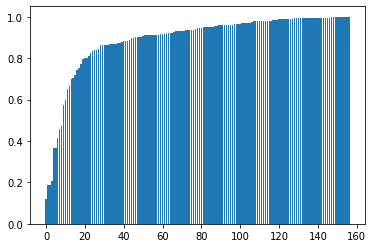

In [216]:
plt.bar(list(range(x.shape[0])), np.sort(np.array(y, dtype='double')))
plt.show()

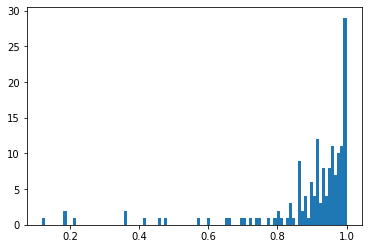

In [232]:
plt.hist(np.array(y, dtype='double'), bins=100)
plt.show()